# Project 3

We've built low-level models, and we've built high-level models. Now, our goal is two-fold:

- Build low-level models into better high-level models, and vice-versa.
- Ensemble our models to make them more reliable

The process for performing hierarchical reconciliation is laid out well [here](https://nixtla.github.io/hierarchicalforecast/examples/tourismsmall.html). I'd recommend following along!

Let's get going!

In [ ]:
! pip install statsforecast mlforecast hierarchicalforecast

In [1]:
data_dir = 'data/project_3_data'

In [2]:
# add imports

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

We're going to start by building a model at the store-deparment level. Our goal is to create a forecast at that level that coherently aggregates up to the state level.

In [4]:
data = (
    pd.read_parquet(f'{data_dir}/sales_data.parquet')
    .reset_index()
    .rename(columns={'date': 'ds', 'sales': 'y'})
    .assign(store_dept_id=lambda df: df.store_id + '_' + df.dept_id)
    .groupby(['ds', 'store_dept_id', 'store_id', 'state_id'])
    .y
    .sum()
    .reset_index()
)
data.head()

,ds,store_dept_id,store_id,state_id,y
0,2013-01-01,TX_1_FOODS_1,TX_1,TX,195
1,2013-01-01,TX_1_FOODS_2,TX_1,TX,271
2,2013-01-01,TX_1_FOODS_3,TX_1,TX,1141
3,2013-01-01,TX_1_HOBBIES_1,TX_1,TX,83
4,2013-01-01,TX_1_HOBBIES_2,TX_1,TX,11


Now it's time to set up our hierarchical data. Use the `aggregate` method from `hierarchicalforecast` to hierarchically structure our data and get the proper summing dataframe.

In [7]:
from hierarchicalforecast.utils import aggregate

# this is the `spec` argument in the `aggregate` function
hierarchy_levels = [['state_id'],
                    ['state_id', 'store_id'],
                    ['state_id', 'store_id', 'store_dept_id']]
y_hier, S_df, tags = aggregate(data, spec=hierarchy_levels)
y_hier = y_hier.reset_index()

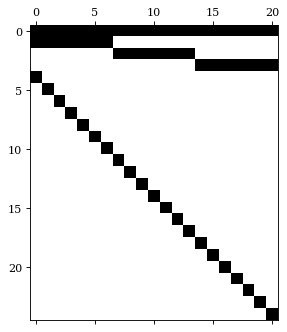

In [8]:
from hierarchicalforecast.utils import HierarchicalPlot

HierarchicalPlot(S_df, tags).plot_summing_matrix()

I went ahead and split your data for you. Train a `StatsForecast` model (any algorithm works, I used AutoARIMA). Be sure to grab the fitted values (i.e. the predictions on the training set), since we'll need that later.

In [36]:
val = y_hier.groupby('unique_id').tail(28)
train = y_hier.drop(val.index)

In [11]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

fcst = StatsForecast(models=[AutoARIMA()], freq='D', df=train)
y_fcst = fcst.forecast(h=28, fitted=True) # forecast on the validation period
y_fitted = fcst.forecast_fitted_values() # fitted values, i.e. forecast on the training data

/home/chris/PycharmProjects/ml_forcasting/venv/lib/python3.11/site-packages/statsforecast/core.py:474: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/home/chris/PycharmProjects/ml_forcasting/venv/lib/python3.11/site-packages/statsforecast/core.py:474: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/home/chris/PycharmProjects/ml_forcasting/venv/lib/python3.11/site-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment var

Use the `StatsForecast.plot` method to visualize your predictions. Try passing `plot_random=False` to see how the model performs at the top levels.

In [13]:
y_fcst

,ds,AutoARIMA
unique_id,,
TX,2016-04-25,11427.172852
TX,2016-04-26,11014.785156
TX,2016-04-27,11015.019531
TX,2016-04-28,11111.439453
TX,2016-04-29,11145.130859
...,...,...
TX/TX_3/TX_3_HOUSEHOLD_2,2016-05-18,172.754364
TX/TX_3/TX_3_HOUSEHOLD_2,2016-05-19,172.757294
TX/TX_3/TX_3_HOUSEHOLD_2,2016-05-20,172.806396


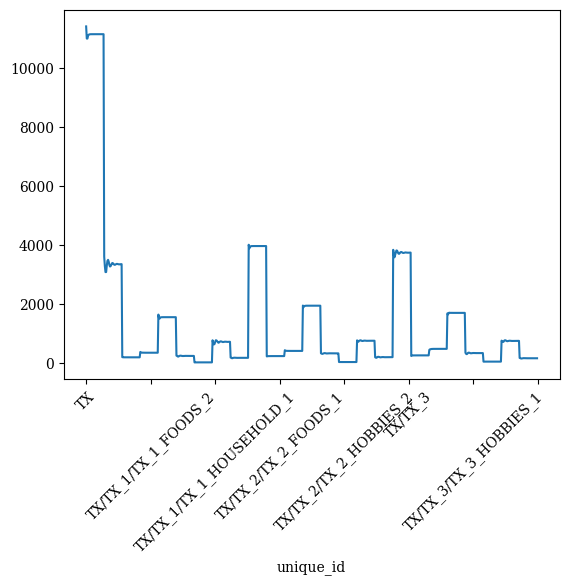

In [21]:
# statsforecast plots go here

y_fcst[('AutoARIMA')].plot()
plt.xticks(rotation = 45);

Now it's time to reconcile! Use the BottomUp, TopDown, and MinTrace reconciliation methods. For TopDown and MinTrace, try out the different methods provided by `hierarchicalforecast` to see which ones work best.

In [24]:
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import BottomUp, TopDown, MinTrace

reconcilers = [
    BottomUp(),
    TopDown(method='forecast_proportions'),
    MinTrace(method='ols')
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)

y_rec = hrec.reconcile(
    Y_hat_df=y_fcst,
    S=S_df,
    tags=tags
)

y_rec_grouped = y_rec.groupby('unique_id', observed=True).head(2).head(10)

In [28]:
y_rec_grouped.head()

,ds,AutoARIMA,AutoARIMA/BottomUp,AutoARIMA/TopDown_method-forecast_proportions,AutoARIMA/MinTrace_method-ols
unique_id,,,,,
TX,2016-04-25,11427.172852,11322.434570,11427.172852,11438.992819
TX,2016-04-26,11014.785156,10842.564453,11014.785156,10974.527706
TX/TX_1,2016-04-25,3618.060059,3524.928711,3597.930908,3596.076178
TX/TX_1,2016-04-26,3298.079102,3250.630127,3341.207031,3327.373259
TX/TX_2,2016-04-25,4022.438232,4021.375488,4000.059326,4011.962888


Plot the results for your raw model predictions against the hierarchical predictions. How closely do the direct, non-hierarchical forecasts agree/disagree? What about the hierarchical forecasts?

Hint: the below plot shows a sample, but the answer to this question lies with `plot_hierarchical_predictions_gap()`. Check out some of the other plotting methods, too!

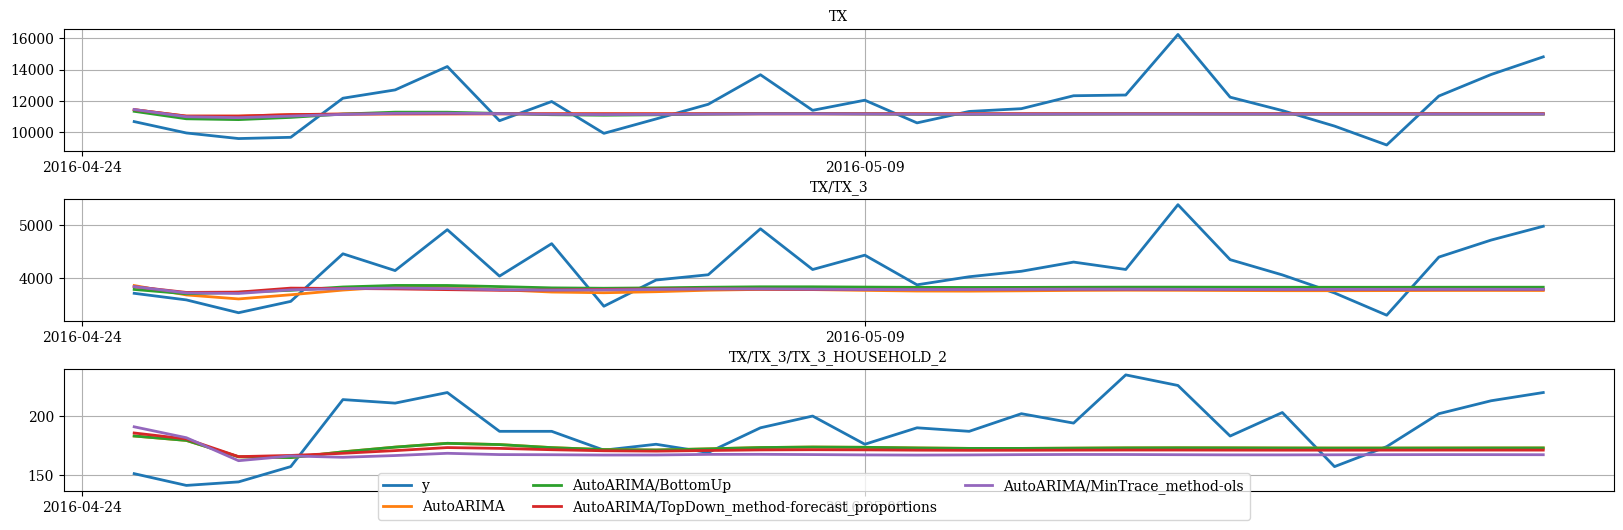

In [29]:
HierarchicalPlot(S_df, tags).plot_hierarchically_linked_series(
    bottom_series='TX/TX_3/TX_3_HOUSEHOLD_2',
    Y_df=val.merge(y_rec, on=['unique_id', 'ds']).set_index('unique_id'),
)

Use the helper code below to calculate RMSSE for every method you tried, at every level of the hierarchy. This code is borrowed and modified from the `hierarchicalforecast` library, because their implementation of `msse` is different than our version. This formulation of RMSSE should line up with the formulation from Project 2.

In [16]:
from hierarchicalforecast.evaluation import HierarchicalEvaluation

def mse(y, y_hat, weights=None, axis=None):
    delta_y = np.square(y - y_hat)
    if weights is not None:
        mse = np.average(delta_y,
                         weights=weights,
                         axis=axis)
    else:
        mse = np.nanmean(delta_y, axis=axis)
    return mse

def rmsse(y, y_hat, y_insample, mask=None, insample_mask=None):
    if mask is None: 
       mask = np.ones_like(y)
       
    eps = np.finfo(float).eps

    norm = mse(y=y_insample[:, 1:], y_hat=y_insample[:, :-1], weights=insample_mask, axis=1)
    loss = mse(y=y, y_hat=y_hat, weights=mask, axis=1)

    loss = np.sqrt(loss / (norm + eps))
    return loss.mean()

In [37]:
val.set_index('unique_id', inplace=True)
train.set_index('unique_id', inplace=True)

evaluation = HierarchicalEvaluation([rmsse]).evaluate(
    Y_hat_df=y_rec,     # your reconciled forecasts
    Y_test_df=val,      # validation actuals DF, with unique_id as index
    tags=tags,          # tags from aggregate()
    Y_df=train          # training actuals DF, with unique_id as index
)

In [39]:
evaluation.head()

,,AutoARIMA,AutoARIMA/BottomUp,AutoARIMA/TopDown_method-forecast_proportions,AutoARIMA/MinTrace_method-ols
level,metric,,,,
Overall,rmsse,0.947331,0.945175,0.957157,0.953764
state_id,rmsse,0.92688,0.914508,0.92688,0.923748
state_id/store_id,rmsse,0.924337,0.910499,0.931934,0.927761
state_id/store_id/store_dept_id,rmsse,0.951589,0.951589,0.962202,0.958908


Answer the following questions:

- What's more accurate, the direct forecast, or the hierarchical methods?
- What's the most accurate method for top-level aggregation (i.e. the `state_id` level)?
- What's the most accurate method for bottom-level aggregation (i.e. the `state_id`/`store_id`/`store_dept_id` level)?

## Ensembling

Now, let's try to ensemble predictions from multiple models.

Below, fit two models -- one `mlforecast` model (could be the same one you used in Project 2), and one `statsforecast` model. You can fit the models at any level you want (just make sure both are fit at the same level), but I'd recommend trying out `item_id`. It's a little faster than at the `id` level, and it gives both models a good opportunity to show their diversity.

Once you've fit both models, be sure to plot some sample predictions.

Don't worry about tuning the performance much here. This is more about seeing ensembling in action than optimizing your individual models!

[Optional, if you have extra time] You can also fit a `neuralforecast` model.

In [3]:
# read in a fresh copy of the data
data = (
    pd.read_parquet('data/project_3_data/sales_data.parquet')
    .reset_index()
    .groupby(['date', 'item_id', 'dept_id', 'cat_id'])
    .sales
    .sum()
    .reset_index()
    .assign(unique_id=lambda df: df.item_id.copy())
    .rename(columns={'date': 'ds', 'sales': 'y'})
    .drop(columns=['item_id', 'dept_id', 'cat_id'])
)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3774662 entries, 0 to 3774661
Data columns (total 3 columns):
 #   Column     Dtype         
---  ------     -----         
 0   ds         datetime64[us]
 1   y          int64         
 2   unique_id  object        
dtypes: datetime64[us](1), int64(1), object(1)
memory usage: 86.4+ MB


In [5]:
val = (data
       .groupby('unique_id')
       .tail(28)
      #  .drop(columns=['item_id', 'dept_id', 'cat_id'])
      #  .sort_values(by='ds', ascending=True)

)
train = (data
         .drop(val.index)
        #  .drop(columns=['item_id', 'dept_id', 'cat_id'])
        #  .sort_values(by='ds', ascending=True)

)

In [6]:
# fit an mlforecast model

import lightgbm as lgb
from mlforecast import MLForecast
from sklearn.linear_model import LinearRegression

fcst = MLForecast(
    models = [LinearRegression()],
    lags=[1],
    freq = 'D'
)
fcst.fit(train)
preds_ml = fcst.predict(28)

In [7]:
preds_ml

,unique_id,ds,LinearRegression
0,FOODS_1_001,2016-04-25,0.418083
1,FOODS_1_001,2016-04-26,0.785014
2,FOODS_1_001,2016-04-27,1.107050
3,FOODS_1_001,2016-04-28,1.389686
4,FOODS_1_001,2016-04-29,1.637741
...,...,...,...
85367,HOUSEHOLD_2_516,2016-05-18,3.268048
85368,HOUSEHOLD_2_516,2016-05-19,3.286286
85369,HOUSEHOLD_2_516,2016-05-20,3.302292
85370,HOUSEHOLD_2_516,2016-05-21,3.316340


Before starting to ensemble, let's check the RMSSE of our individual models. Our modified version of RMSSE takes predictions in a rectangular shape, with each row being one `unique_id` and each column being one of the 28 predictions for the validation set. That results in an array of shape `[n_unique_ids, 28]`. We need to do the same thing for the training data (`y_insample` here) to create the scale (the denominator). Finally, we create a mask to tell the RMSSE function not to calculate the scale value before each `unique_id` has its first sale, since we don't calculate the loss over those periods.

This code assumes you stored your `mlforecast` predictions in `preds_ml` and your `statsforecast` predictions in `preds_sf`.

Modify it to suit your needs!

In [10]:
from statsforecast.core import StatsForecast
from statsforecast.models import AutoETS
fcst = StatsForecast(models=[AutoETS()], freq='D', df=train)

# preds_sf = fcst.forecast(h=28).reset_index()

preds_sf = pd.read_parquet('data/project_3_preds_sf_ets.parquet')

/home/chris/PycharmProjects/ml_forcasting/venv/lib/python3.11/site-packages/statsforecast/core.py:474: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(


In [11]:
preds_sf

,unique_id,ds,AutoETS
0,FOODS_1_001,2016-04-25,1.030512
1,FOODS_1_001,2016-04-26,0.986365
2,FOODS_1_001,2016-04-27,1.190499
3,FOODS_1_001,2016-04-28,1.211763
4,FOODS_1_001,2016-04-29,1.445122
...,...,...,...
85367,HOUSEHOLD_2_516,2016-05-18,0.486978
85368,HOUSEHOLD_2_516,2016-05-19,0.522174
85369,HOUSEHOLD_2_516,2016-05-20,0.592548
85370,HOUSEHOLD_2_516,2016-05-21,0.817357


In [14]:
y = val.sort_values(['unique_id', 'ds']).y.values.reshape(-1, 28)
# y_hat_ml = preds_ml.sort_values(['unique_id', 'ds']).LGBMRegressor.values.reshape(-1, 28)
y_hat_ml = preds_ml.sort_values(['unique_id', 'ds']).LinearRegression.values.reshape(-1, 28)
y_hat_sf = preds_sf.sort_values(['unique_id', 'ds']).AutoETS.values.reshape(-1, 28)
y_insample = train.sort_values(['unique_id', 'ds']).y.values.reshape(-1, 1210)
insample_mask = (y_insample.cumsum(axis=1) > 0).astype(int)[:, 1:]

In [17]:
print(f'LightGBM Tweedie RMSSE: {rmsse(y, y_hat_ml, y_insample, insample_mask=insample_mask)}')
print(f'AutoETS RMSSE: {rmsse(y, y_hat_sf, y_insample, insample_mask=insample_mask)}')

LightGBM Tweedie RMSSE: 1.4312739931186886
AutoETS RMSSE: 0.7815112561058867


Create `y_hat`, which is a NumPy array of all of your model's predictions combined along a new axis. `y_hat` should be of shape `[n_models, n_unique_ids, 28]`. So, if you only fit one `mlforecast` model and one `statsforecast` model, it'd be of shape `[2, n_unique_ids, 28]`.

The reason we're doing this is because we're going to have a single weight for each model, and that weight will be between 0 and 1. So, that means we can take a weighted average across the first dimension using those weights to calculate our ensemble. But, that after this!

Hint: try running the following code:

```
arr = np.array([
    [0, 1, 2],
    [3, 4, 5],
    [6, 7, 8],
    [9, 0, 1],
])
print(arr.shape)
print(arr[None, :].shape)
```

In [19]:
y_hat = np.array([y_hat_ml, y_hat_sf])

Calculate `y_hat_avg` in `ensemble_metric`. `y_hat_avg` is a weighted average of `y_hat` along the first dimension, and is weighted according to `weights`, which is a list of floats of length `n_models`. There are some tests in there to help you out!

Here's what you have to do:

1. Finish the definition for `init_guess`, which should be a list with length equal to the number of models you trained. Initialize it such that the weights for each model are between 0 and 1 and are equal for every model.
2. Run the code and make note of the RMSSE value. This is the RMSSE for a simple average of your predictions.

In [21]:
from functools import partial

def ensemble_metric(weights, y, y_hat, y_insample, insample_mask):
    y_hat_avg = np.average(y_hat, axis=0, weights=weights)
    assert y_hat_avg.ndim == 2, 'y_hat_avg has {y_hat_avg.ndim} dimensions, but it must be 2D. Did you calculate a weighted average over the first dimension?'
    assert y_hat_avg.shape == y.shape, 'y_hat_avg and y must have the same shape. y_hat_avg has shape {y_hat_avg.shape}, but y has shape {y.shape}'
    return rmsse(y, y_hat_avg, y_insample, insample_mask=insample_mask)

ensemble_metric = partial(ensemble_metric, y=y, y_hat=y_hat, y_insample=y_insample, insample_mask=insample_mask)

# Our first guess is setting all weights equal to each other, such that they sum up to 1
n_models = 2  # replace with the actual number of models you've trained

# Initialize weights equally for each model
init_guess = [1 / n_models] * n_models
print(f'Inital Blend RMSSE: {ensemble_metric(init_guess):.6f}')

Inital Blend RMSSE: 0.999240


On line 16, replace `oof_names` with a list of the names of your models in the order that you added them to `y_hat`.

In [22]:
from scipy.optimize import minimize

bnds = [(0, 1) for _ in range(y_hat.shape[0])] # Weights must be between 0 and 1

res_scipy = minimize(
    fun=ensemble_metric,
    x0=init_guess,
    method='Powell',
    bounds=bnds,
    options=dict(maxiter=1_000_000),
    tol=1e-8
)

print(f'Optimised Blend RMSSE: {res_scipy.fun:.6f}')
print(f'Optimised Weights: {res_scipy.x}')
print('-' * 70)

oof_names = ['LinearRegression', 'AutoETS']
for n, key in enumerate(oof_names):
    print(f'{key} Optimised Weights: {res_scipy.x[n]:.6f}')

ws = [ res_scipy.x[i] for i in range(len(oof_names))]

# normalize the weights so they sum to 1
weights = ws / np.sum(ws)
print(f'Normalized weights:')
print(weights)

Optimised Blend RMSSE: 0.781097
Optimised Weights: [0.0088975  0.50000008]
----------------------------------------------------------------------
LinearRegression Optimised Weights: 0.008897
AutoETS Optimised Weights: 0.500000
Normalized weights:
[0.01748387 0.98251613]


Finally, answer the following questions:

1. How did the accuracy of your single model compare to the accuracy of the optimized ensemble?
2. How did the simple average ensemble compare to the optimized ensemble?
3. Does it make sense how the models were weighted? Did the most accurate model get the largest weight?
4. How might you combine hierarchical forecasting with ensembling?